In [124]:
import pandas as pd
import numpy as np
#from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm
import time
from time import sleep

def get_distance_from_paydays(date):
    end_of_month = date.daysinmonth
    distance_to_1st = 0 if date.day >=15 else 15 - date.day
    distance_to15th = 0 if date.day < 15 else end_of_month - date.day
    return distance_to_1st + distance_to15th

def std(x): return np.std(x)

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            if str(col_type) == numerics:
                c_min = df[col].min()
                c_max = df[col].max()

                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            if str(col_type)[:5] == 'float':
                c_min = df[col].min()
                c_max = df[col].max()

                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

## Simple "Memory profilers" to see memory usage
def get_memory_usage():
    return np.round(psutil.Process(os.getpid()).memory_info()[0]/2.**30, 2) 
        
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)


In [125]:
if True:
    df_train = pd.read_csv('../../dataset/train/train_converted.csv')
    df_test  = pd.read_csv('../../dataset/test/test_converted.csv')
    df_train = df_train[['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA','Z_WEEK','Z_WEEK_DATE','Demanda']].groupby(['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA','Z_WEEK','Z_WEEK_DATE']).sum().reset_index()
    df_test = df_test[['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA','Z_WEEK','Z_WEEK_DATE','Demanda']].groupby(['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA','Z_WEEK','Z_WEEK_DATE']).sum().reset_index()

else:

    df_train = pd.read_pickle('../../dataset/train/train_converted_fill.pkl')
    df_test  = pd.read_pickle('../../dataset/test/test_converted_fill.pkl')

#df_train = reduce_mem_usage(df_train)
#df_test = reduce_mem_usage(df_test)


df_train.replace(['',np.inf, -np.inf, np.nan],0,inplace=True)
df_test.replace(['',np.inf, -np.inf, np.nan],0,inplace=True)

In [126]:
print('Creating date_block_num ...')
N_submission = df_test.shape[0]
N_sales      = df_train.shape[0]

print(df_train.shape,df_test.shape)

dates = (set(df_train['Z_WEEK'].unique()) | set(df_test['Z_WEEK'].unique()))#df_auxiliar['Z_WEEK'].unique()
dates = sorted(dates)

dict_dates = {}
for idx,date in enumerate(dates):
    dict_dates[date] =idx
    
    
df_train['date_block_num'] = df_train['Z_WEEK'].map(dict_dates)
df_test['date_block_num'] = df_test['Z_WEEK'].map(dict_dates)

df_train.replace(['',np.inf, -np.inf, np.nan],0,inplace=True)
df_test.replace(['',np.inf, -np.inf, np.nan],0,inplace=True)

print('Creating date_block_num completed!')


print('Preprocessing TRAINING DATASET ...')


df_train['Z_WEEK_DATE'] = pd.to_datetime(df_train['Z_WEEK_DATE'])
df_train['days_from_payday'] = df_train['Z_WEEK_DATE'].apply(get_distance_from_paydays)


statistics_columns = [ ]

#df_train["log_Demanda"] = np.log(df_train['Demanda'] + 1e-8)
#df_test["log_Demanda"] = np.log(1e-8)
#statistics_columns.append('log_Demanda')

'''
bar1 = tqdm([
    ['Z_MODELO'],
    ['Z_PUNTO_VENTA'],
    ['Z_GAMA'],
    ['Z_MODELO','Z_PUNTO_VENTA'],
    ['Z_MODELO','Z_GAMA'],
    ['Z_PUNTO_VENTA','Z_GAMA'],
    ['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA']], position=0, desc="i",colour='green', ncols=80)
time.sleep(1)

bar2 = tqdm(['mean'], position=1, desc="j", colour='red', ncols=80, leave=False) #'std','max','min','sum'
time.sleep(1)

unique_columns = [ ]
        
for column_names in bar1:
    bar1.update()
    bar2.refresh()  #force print final state
    time.sleep(0.1)
    bar2.reset()  #reuse bar
    for statistic in bar2:
        
        new_column_name = statistic+'_sales_by_'+'_'.join(column_names)
        #df_train[new_column_name] = df_train.groupby(["Z_WEEK_DATE"]+column_names, observed=True).Demanda.transform(statistic)
        if statistic == 'mean':
            df_agg = df_train.groupby(["Z_WEEK"]+column_names, observed=True).Demanda.mean()
        if statistic == 'std':
            df_agg = df_train.groupby(["Z_WEEK"]+column_names, observed=True).Demanda.std(ddof=0)
        if statistic == 'max':
            df_agg = df_train.groupby(["Z_WEEK"]+column_names, observed=True).Demanda.max()
        if statistic == 'min':
            df_agg = df_train.groupby(["Z_WEEK"]+column_names, observed=True).Demanda.min()
        if statistic == 'sum':
            df_agg = df_train.groupby(["Z_WEEK"]+column_names, observed=True).Demanda.sum()        
        if df_agg.shape[0] >= df_train.shape[0]*0.7:
            unique_columns.append([["Z_WEEK"]+column_names,new_column_name])
            continue
        
        df_agg = df_agg.reset_index()
        df_agg.columns = df_agg.columns.str.replace('Demanda', new_column_name)
        
        df_train = df_train.merge(df_agg,on=["Z_WEEK"]+column_names,how='left')
        statistics_columns.append(new_column_name)
        bar2.update()
        time.sleep(0.05)
#'''

df_train['dayofweek'] = df_train['Z_WEEK_DATE'].dt.dayofweek.astype('str').astype('category')
df_train['month'] = df_train['Z_WEEK_DATE'].dt.month.astype('str').astype('category')
df_train['dayofyear'] = df_train['Z_WEEK_DATE'].dt.dayofyear.astype('str').astype('category')

df_train.drop(columns=['Z_WEEK_DATE'],inplace=True)
df_train.drop(columns=['Z_WEEK'],inplace=True)

print('Preprocessing TRAINING DATASET COMPLETED!')
print('Preprocessing TESTING DATASET ...')


df_test['Z_WEEK_DATE'] = pd.to_datetime(df_test['Z_WEEK_DATE'])
df_test['days_from_payday'] = df_test['Z_WEEK_DATE'].apply(get_distance_from_paydays)

inv_dict_dates = {v: k for k, v in dict_dates.items()}
#df_test['Z_WEEK'] = df_test['date_block_num'].map(inv_dict_dates)
df_test = df_test[['date_block_num','Z_MODELO','Z_PUNTO_VENTA','Z_GAMA',"Demanda","Z_WEEK_DATE"]]

df_test['dayofweek'] = df_test['Z_WEEK_DATE'].dt.dayofweek.astype('str').astype('category')
df_test['month'] = df_test['Z_WEEK_DATE'].dt.month.astype('str').astype('category')
df_test['dayofyear'] = df_test['Z_WEEK_DATE'].dt.dayofyear.astype('str').astype('category')



df_test['days_from_payday'] = df_test['Z_WEEK_DATE'].apply(get_distance_from_paydays)
df_test.drop(columns=['Z_WEEK_DATE'],inplace=True)

print('Preprocessing TESTING DATASET COMPLETED!')


Creating date_block_num ...
(2358650, 6) (471730, 6)
Creating date_block_num completed!
Preprocessing TRAINING DATASET ...
Preprocessing TRAINING DATASET COMPLETED!
Preprocessing TESTING DATASET ...
Preprocessing TESTING DATASET COMPLETED!


In [127]:
#%timeit df_train.to_pickle('../../dataset/train/train_converted_fill_process.pkl')

In [128]:
#%timeit df_test.to_pickle('../../dataset/test/test_converted_fill_process.pkl')

In [129]:
print(df_train.shape)
#print(list(df_train.columns))
df_train.head(2)

(2358650, 9)


Z_MODELO Z_PUNTO_VENTA Z_GAMA  Demanda  date_block_num  days_from_payday  \
0    MOD_1       PVENT_1  GAM_1        0               0                14   
1    MOD_1       PVENT_1  GAM_1        0               1                 7   

  dayofweek month dayofyear  
0         0     5       137  
1         0     5       144

In [130]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2358650 entries, 0 to 2358649
Data columns (total 9 columns):
 #   Column            Dtype   
---  ------            -----   
 0   Z_MODELO          object  
 1   Z_PUNTO_VENTA     object  
 2   Z_GAMA            object  
 3   Demanda           int64   
 4   date_block_num    int64   
 5   days_from_payday  int64   
 6   dayofweek         category
 7   month             category
 8   dayofyear         category
dtypes: category(3), int64(3), object(3)
memory usage: 114.7+ MB


In [131]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

numeric_columns = df_train.select_dtypes(include=numerics).columns
numeric_columns

Index(['Demanda', 'date_block_num', 'days_from_payday'], dtype='object')

In [132]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = StandardScaler()
for column in numeric_columns:
    print(column)
    if column in ['Demanda','date_block_num']:
        continue
    else:
        
        df_train[column] = scaler.fit_transform(df_train[column].values.reshape(-1,1))
        
        if column in df_test.columns:
            df_test[column]  = scaler.transform(df_test[column].values.reshape(-1,1))

Demanda
date_block_num
days_from_payday


In [133]:
import warnings
import numpy as np
import pandas as pd
import copy
from pathlib import Path
import torch
import torch.nn as nn

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

import pytorch_forecasting
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer,EncoderNormalizer

from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss,RMSE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import os
# configure network and trainer
pl.seed_everything(42)

import torch
torch.manual_seed(0)

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

Global seed set to 42


In [134]:
prediction_steps = df_test['date_block_num'].nunique()
prediction_steps

10

In [135]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2358650 entries, 0 to 2358649
Data columns (total 9 columns):
 #   Column            Dtype   
---  ------            -----   
 0   Z_MODELO          object  
 1   Z_PUNTO_VENTA     object  
 2   Z_GAMA            object  
 3   Demanda           int64   
 4   date_block_num    int64   
 5   days_from_payday  float64 
 6   dayofweek         category
 7   month             category
 8   dayofyear         category
dtypes: category(3), float64(1), int64(2), object(3)
memory usage: 114.7+ MB


In [136]:
df_train['Demanda'] = df_train['Demanda'].astype(np.float32)
df_test['Demanda'] = df_test['Demanda'].astype(np.float32)

In [137]:
for column in df_train.columns:
    print(column,'train',df_train[df_train[column]==358].shape)
    if column in df_test.columns:
        print(column,'test ',df_test[df_test[column]==358].shape)

Z_MODELO train (0, 9)
Z_MODELO test  (0, 9)
Z_PUNTO_VENTA train (0, 9)
Z_PUNTO_VENTA test  (0, 9)
Z_GAMA train (0, 9)
Z_GAMA test  (0, 9)
Demanda train (1, 9)
Demanda test  (0, 9)
date_block_num train (0, 9)
date_block_num test  (0, 9)
days_from_payday train (0, 9)
days_from_payday test  (0, 9)
dayofweek train (0, 9)
dayofweek test  (0, 9)
month train (0, 9)
month test  (0, 9)
dayofyear train (0, 9)
dayofyear test  (0, 9)


In [138]:
df_train.head(2)

Z_MODELO Z_PUNTO_VENTA Z_GAMA  Demanda  date_block_num  days_from_payday  \
0    MOD_1       PVENT_1  GAM_1      0.0               0          1.556904   
1    MOD_1       PVENT_1  GAM_1      0.0               1         -0.004461   

  dayofweek month dayofyear  
0         0     5       137  
1         0     5       144

In [139]:
for column in ['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA']:
    df_train[column] = df_train[column].astype(str)
    df_test[column] = df_test[column].astype(str)

In [140]:
#'day_of_week', 'day', 'is_month_end', 'day_of_year',  'is_quarter_start', 'year', 'month', 'is_year_start', 'is_month_start', 
# 'I103','S103', 'C101','I100' , 'C100', 'ID', 'I102','S102',, 'S101', 'S100', 'item_id', 'date_block_num', 'I101'
max_prediction_length = prediction_steps

max_encoder_length = 40

training_cutoff = df_train['date_block_num'].max() - max_prediction_length

training = TimeSeriesDataSet(
    df_train[lambda x: x['date_block_num'] <= training_cutoff],
    time_idx='date_block_num',
    target="Demanda",
    group_ids=['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA'],
    min_encoder_length= max_encoder_length // 2,   
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
        
    static_categoricals=['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA'],
    
    time_varying_known_categoricals=[
                                     "month", 
                                     "dayofweek",
                                     "dayofyear"],
    
    time_varying_known_reals=['days_from_payday'], # "date_block_num",
    time_varying_unknown_categoricals=[],#['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA'],  
    time_varying_unknown_reals= statistics_columns,#+['date_block_num'],#'Demanda',  statistics_columns+['Demanda'],#'date_block_num'],
       
    target_normalizer=GroupNormalizer(
        groups=['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA'], transformation="softplus"
    ),  # use softplus and normalize by group    
    
    categorical_encoders={                          
                          "Z_GAMA":  pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
                          "Z_MODELO": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
                          "Z_PUNTO_VENTA": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
                          "dayofweek": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
                          "month": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
                          "dayofyear": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
                          "date_block_num": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
                         },
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,
)

In [310]:
validation = TimeSeriesDataSet.from_dataset(training, df_train, predict=True, stop_randomization=True)

batch_size = 64
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=3)

val_dataloader   = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=3)

In [311]:
from pytorch_forecasting.metrics import MultiHorizonMetric
from typing import Dict, List, Tuple, Union
from pytorch_forecasting.metrics import TweedieLoss,NegativeBinomialDistributionLoss,BetaDistributionLoss,MAE,MAPE,MASE,QuantileLoss,RMSE,SMAPE
from pytorch_lightning.callbacks import ModelCheckpoint

composite_metric_smape_mae = SMAPE() + 1e-4 * MAE()

#from pytorch_forecasting.metrics import MAE, AggregationMetric  # NOT WORKING
#composite_metric_smape_aggmae = MAE() + AggregationMetric(metric=MAE())



'''
def tweedieloss(y_true, y_pred):
    p=1.5
    a = K.pow(y_true, 2-p)/((1-p) * (2-p))
    b = K.pow(y_pred, 1-p)/(1-p)
    c = K.pow(y_pred, 2-p)/(2-p)
    dev = 2 * (a -y_true *b  +c)
    return K.mean(dev)
'''
class new_tweedieloss(MultiHorizonMetric):
    def __init__(self, reduction="none", **kwargs):
        super().__init__(reduction=reduction, **kwargs)
    def loss(self, y_pred: Dict[str, torch.Tensor], target):
        p = 1.4#torch.tensor([1.01], dtype=torch.float16)
        eps = 1e-10
        
        factor = 1
        
        if y_pred.sum() <= eps:
            print("wtahsd!!")
            factor = 1e19
            # y_pred = np.random.rand(len(y_pred))
        else:
            # y_pred = np.where(y_pred<0, eps, y_pred)  #Filter 0 and negative values 
            y_pred = torch.abs(y_pred)
        #.requires_grad_(True)
        preds = self.to_prediction(y_pred) + eps
        #'''
        
        a = target*(torch.pow(preds,1-p))/(1-p)
        b = torch.pow(preds,2-p)/(2-p)
        tweddie = torch.mean((-a+b)/factor)
        '''
        a = torch.pow(target, 2-p)/((1-p) * (2-p))
        b = torch.pow(preds, 1-p)/(1-p)
        c = torch.pow(preds, 2-p)/(2-p)
        tweddie = -2 * (a -target *b  +c)
        '''
        return tweddie
    
    
    
loss_metrics =[
    [RMSE(),'RMSE',1],    
    [MAE(),'MAE',1],
    [MAPE(),'MAPE',1],
    [MASE(),'MASE',1],
    #[composite_metric_smape_mae,'composite_metric_smape_mae',1],
    [QuantileLoss(),'QuantileLoss',7],
    [new_tweedieloss(),'new_tweedieloss',1]
]

In [312]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

Quadro RTX 5000
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


********************
 LOSS FUNCTION =  new_tweedieloss


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 33.1k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Finding best initial lr: 100%|██████████| 100/100 [00:11<00:00,  8.76it/s]
Restoring states from the checkpoint path at /notebooks/entel-2022/DATATHON-ENTEL-2022---Reto2/notebooks/cristian/.lr_find_ce59d07c-9a53-4107-b5e3-b9eb2a245f2e.ckpt


suggested learning rate: 1.2022644346174128e-06


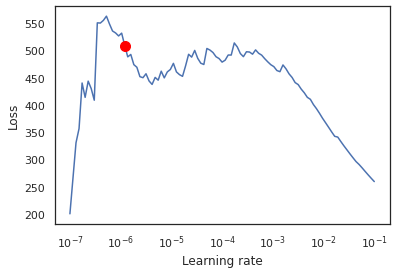

 LOSS FUNCTION =  new_tweedieloss  LR =  1.2022644346174128e-06


In [313]:
sucess_list = []

#for loss_function, name_loss_function, loss_output_size in [[new_tweedieloss(),'new_tweedieloss',1]]:

name_loss_function = 'new_tweedieloss'
loss_output_size   = 1


print('*'*20)
print(' LOSS FUNCTION = ',name_loss_function)


trainer = pl.Trainer(gpus=1,gradient_clip_val=0.1)
trainer.enforce_positive_output=True

tft = TemporalFusionTransformer.from_dataset(
    training,

    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=loss_output_size,  # 7 quantiles by default
    #loss = new_tweedieloss(),#.to(device),
    loss = new_tweedieloss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

# find optimal learning rate
res = trainer.tuner.lr_find(

    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=0.1,
    min_lr=1e-7,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()


learning_rate = res.suggestion()

print(' LOSS FUNCTION = ',name_loss_function,' LR = ',learning_rate)
    


In [314]:
learning_rate

1.2022644346174128e-06

In [315]:
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate= learning_rate,
    hidden_size=16,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=loss_output_size, 
    loss = new_tweedieloss(),
    log_interval=50,  
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 32.7k


In [316]:
#Early Stopping 
MIN_DELTA  = 1e-7
PATIENCE   = 40

#PL Trainer
MAX_EPOCHS = 10000

GPUS = 1



# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=MIN_DELTA, patience=PATIENCE, verbose=False, mode="min")
lr_logger = LearningRateMonitor(logging_interval='epoch')  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard



checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='../../results/models/tft/',
    filename='MODEL_tft-'+name_loss_function+'-loss-epoch_{epoch:02d}-val_loss_{val_loss:.3f}',
    auto_insert_metric_name=False,
    
 )

trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    gpus=GPUS,
    #weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=50,#oment in for training, running valiation every 30 batches
    #fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback,checkpoint_callback],
    #log_every_n_steps=10,
    logger=logger,
)
trainer.enforce_positive_output=True


print('holas')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


holas


In [ ]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | new_tweedieloss                 | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 13.5 K
3  | prescalers                         | ModuleDict                      | 80    
4  | static_variable_selection          | VariableSelectionNetwork        | 2.3 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.6 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.6 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm 

Epoch 0:  40%|████      | 50/124 [00:06<00:09,  7.65it/s, loss=319, v_num=41, train_loss_step=204.0]      
Validation: 0it [00:00, ?it/s]
Epoch 1:  40%|████      | 50/124 [00:06<00:10,  7.23it/s, loss=462, v_num=41, train_loss_step=313.0, val_loss=166.0, train_loss_epoch=398.0]  
Validation: 0it [00:00, ?it/s]
Epoch 2:  40%|████      | 50/124 [00:07<00:10,  7.09it/s, loss=395, v_num=41, train_loss_step=354.0, val_loss=166.0, train_loss_epoch=397.0]  
Validation: 0it [00:00, ?it/s]
Epoch 3:  40%|████      | 50/124 [00:06<00:10,  7.22it/s, loss=494, v_num=41, train_loss_step=205.0, val_loss=165.0, train_loss_epoch=440.0]  
Validation: 0it [00:00, ?it/s]
Epoch 4:  40%|████      | 50/124 [00:06<00:10,  7.21it/s, loss=416, v_num=41, train_loss_step=479.0, val_loss=165.0, train_loss_epoch=385.0]  
Validation: 0it [00:00, ?it/s]
Epoch 5:  40%|████      | 50/124 [00:06<00:10,  7.18it/s, loss=342, v_num=41, train_loss_step=528.0, val_loss=165.0, train_loss_epoch=339.0] 
Validation: 0it [00:00, 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 176:  40%|████      | 50/124 [00:07<00:10,  7.07it/s, loss=174, v_num=41, train_loss_step=108.0, val_loss=108.0, train_loss_epoch=265.0]
Validation: 0it [00:00, ?it/s]
Epoch 177:  40%|████      | 50/124 [00:07<00:10,  6.91it/s, loss=244, v_num=41, train_loss_step=102.0, val_loss=107.0, train_loss_epoch=168.0] 
Validation: 0it [00:00, ?it/s]
Epoch 205:  40%|████      | 50/124 [00:07<00:10,  7.02it/s, loss=195, v_num=41, train_loss_step=126.0, val_loss=101.0, train_loss_epoch=164.0]
Validation: 0it [00:00, ?it/s]
Epoch 206:  40%|████      | 50/124 [00:07<00:10,  7.07it/s, loss=137, v_num=41, train_loss_step=103.0, val_loss=100.0, train_loss_epoch=183.0] 
Validation: 0it [00:00, ?it/s]
Epoch 207:  40%|████      | 50/124 [00:07<00:10,  7.01it/s, loss=191, v_num=41, train_loss_step=89.20, val_loss=100.0, train_loss_epoch=173.0] 
Validation: 0it [00:00, ?it/s]
Epoch 208:  40%|████      | 50/124 [00:07<00:10,  6.98it/s, loss=172, v_num=41, train_loss_step=355.0, val_loss=99.90, train_lo

In [321]:
print('hola')

hola


In [322]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
print(best_model_path)
best_model_name = best_model_path.split('/')[-1]
print('best_model_name = ',best_model_name)

/notebooks/entel-2022/DATATHON-ENTEL-2022---Reto2/results/models/tft/MODEL_tft-new_tweedieloss-loss-epoch_551-val_loss_57.007.ckpt
best_model_name =  MODEL_tft-new_tweedieloss-loss-epoch_551-val_loss_57.007.ckpt


In [323]:
# calcualte root mean squared error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
val_predictions = best_tft.predict(val_dataloader)
criterion = nn.MSELoss()
rmse_val = torch.sqrt(criterion(actuals,val_predictions)).item()
print('rmse_val = ',rmse_val)
#rmse_val =  4.5
#rmse_val =  6.663715362548828 TWEDDDIE P 1.7 EPOCHS 10


rmse_val =  5.196934223175049


In [324]:
print('max_prediction_length:',max_prediction_length)
print('max_encoder_length   :',max_encoder_length)

max_prediction_length: 10
max_encoder_length   : 60


In [325]:
# select last 30 days from data (max_encoder_length is 24)
encoder_data = df_train[lambda x: x.date_block_num > x.date_block_num.max() - max_encoder_length]

print(encoder_data['date_block_num'].min(),encoder_data['date_block_num'].max())
#print(encoder_data['DATE'].min(),encoder_data['DATE'].max())
encoder_data

0 49


Z_MODELO Z_PUNTO_VENTA Z_GAMA  Demanda  date_block_num  \
0          MOD_1       PVENT_1  GAM_1      0.0               0   
1          MOD_1       PVENT_1  GAM_1      0.0               1   
2          MOD_1       PVENT_1  GAM_1      0.0               2   
3          MOD_1       PVENT_1  GAM_1      0.0               3   
4          MOD_1       PVENT_1  GAM_1      0.0               4   
...          ...           ...    ...      ...             ...   
2358645   MOD_99      PVENT_99  GAM_3      0.0              45   
2358646   MOD_99      PVENT_99  GAM_3      0.0              46   
2358647   MOD_99      PVENT_99  GAM_3      1.0              47   
2358648   MOD_99      PVENT_99  GAM_3      1.0              48   
2358649   MOD_99      PVENT_99  GAM_3      1.0              49   

         days_from_payday dayofweek month dayofyear  
0                1.556904         0     5       137  
1               -0.004461         0     5       144  
2               -1.565826         0     5       151  
3                0.218591         0     6       158  
4               -1.342774         0     6       165  
...                   ...       ...   ...       ...  
2358645         -0.896669         0     3        87  
2358646          0.887747         0     4        94  
2358647         -0.673617         0     4       101  
2358648          1.110799         0     4       108  
2358649         -0.450565         0     4       115  

[2358650 rows x 9 columns]

In [326]:

last_data = df_train[df_train['date_block_num'].isin([idx  -  max_prediction_length for idx in df_test['date_block_num'].unique()])]
last_data['date_block_num'] = last_data['date_block_num'] + max_prediction_length

decoder_data = pd.merge(df_test[[col for col in df_test.columns if 'Demanda' not in col]], 
        last_data[['date_block_num','Z_MODELO','Z_PUNTO_VENTA','Z_GAMA',"Demanda"]+statistics_columns],
        on = ['date_block_num', 'Z_MODELO','Z_PUNTO_VENTA','Z_GAMA',],
                        how='left'
        )


encoder_data.replace([np.inf, -np.inf, np.nan],0,inplace=True)
decoder_data.replace([np.inf, -np.inf, np.nan],0,inplace=True)


# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

In [327]:
last_data[['date_block_num','Z_MODELO','Z_PUNTO_VENTA','Z_GAMA',"Demanda"]+statistics_columns]

date_block_num Z_MODELO Z_PUNTO_VENTA Z_GAMA  Demanda
40                   50    MOD_1       PVENT_1  GAM_1    117.0
41                   51    MOD_1       PVENT_1  GAM_1    175.0
42                   52    MOD_1       PVENT_1  GAM_1    272.0
43                   53    MOD_1       PVENT_1  GAM_1    358.0
44                   54    MOD_1       PVENT_1  GAM_1    445.0
...                 ...      ...           ...    ...      ...
2358645              55   MOD_99      PVENT_99  GAM_3      0.0
2358646              56   MOD_99      PVENT_99  GAM_3      0.0
2358647              57   MOD_99      PVENT_99  GAM_3      1.0
2358648              58   MOD_99      PVENT_99  GAM_3      1.0
2358649              59   MOD_99      PVENT_99  GAM_3      1.0

[471730 rows x 5 columns]

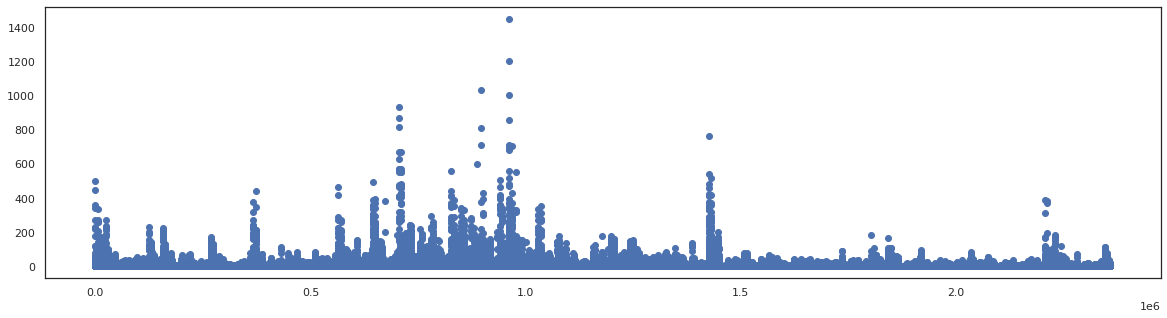

In [328]:
import matplotlib.pyplot as plt

aux = encoder_data['Demanda'].values

fig = plt.figure(figsize=(20,5))
plt.plot(aux,'o')
plt.show()

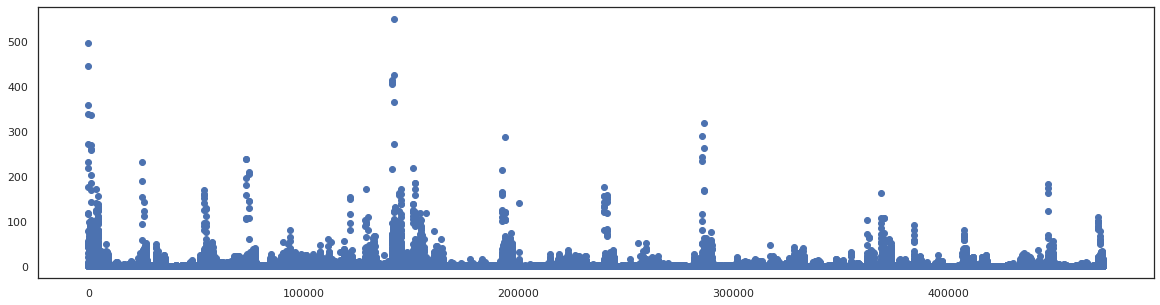

In [329]:
import matplotlib.pyplot as plt

aux = decoder_data['Demanda'].values

fig = plt.figure(figsize=(20,5))
plt.plot(aux,'o')
plt.show()

In [330]:
new_raw_predictions = best_tft.predict(new_prediction_data, mode="prediction", return_x=False)

In [331]:
predictions = pd.DataFrame(new_raw_predictions.numpy()).T
predictions['date_block_num'] = sorted(df_test['date_block_num'].unique())
predictions = pd.melt(predictions, id_vars=['date_block_num'])
predictions = predictions.sort_values(['date_block_num', 'variable']).reset_index(drop=True)
df_test[['date_block_num','Z_MODELO','Z_PUNTO_VENTA','Z_GAMA']].sort_values(['date_block_num', 'Z_MODELO','Z_PUNTO_VENTA','Z_GAMA']).reset_index(drop=True)
df_test2 = df_test.join(predictions['value'])

In [332]:
df_test2.head()

date_block_num Z_MODELO Z_PUNTO_VENTA Z_GAMA  Demanda dayofweek month  \
0              50    MOD_1       PVENT_1  GAM_1      0.0         0     5   
1              51    MOD_1       PVENT_1  GAM_1      0.0         0     5   
2              52    MOD_1       PVENT_1  GAM_1      0.0         0     5   
3              53    MOD_1       PVENT_1  GAM_1      0.0         0     5   
4              54    MOD_1       PVENT_1  GAM_1      0.0         0     5   

  dayofyear  days_from_payday     value  
0       122          1.333851  0.000290  
1       129         -0.227513  0.000281  
2       136          1.779956  0.000289  
3       143          0.218591  0.000291  
4       150         -1.342774  0.000290

In [333]:
import pickle

reverse_mapping_file = '../../utils/reverse_dict_mapping_list.txt'

with open(reverse_mapping_file, 'rb') as f:
    reverse_mapping = pickle.load( f)

In [334]:
#reverse_mapping#

In [335]:
#descriptive_columns = ['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA']
descriptive_columns = ['Z_MARCA', 'Z_GAMA', 'Z_MODELO',
                       'Z_DEPARTAMENTO', 'Z_PUNTO_VENTA']
i=0
for column in descriptive_columns:
    if column in df_test2.columns:
        df_test2[column] = df_test2[column].map(reverse_mapping[i])
    i+=1

In [336]:
df_test2.head()

date_block_num                                           Z_MODELO  \
0              50  b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...   
1              51  b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...   
2              52  b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...   
3              53  b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...   
4              54  b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...   

                                       Z_PUNTO_VENTA  \
0  da45328ba820604eb99694768f2a430cd933d161601dcb...   
1  da45328ba820604eb99694768f2a430cd933d161601dcb...   
2  da45328ba820604eb99694768f2a430cd933d161601dcb...   
3  da45328ba820604eb99694768f2a430cd933d161601dcb...   
4  da45328ba820604eb99694768f2a430cd933d161601dcb...   

                                              Z_GAMA  Demanda dayofweek month  \
0  76df0c6db32d4e04e0ef6a3a6a1e1686677e34308d9435...      0.0         0     5   
1  76df0c6db32d4e04e0ef6a3a6a1e1686677e34308d9435...      0.0         0     5   
2  76df0c6db32d4e04e0ef6a3a6a1e1686677e34308d9435...      0.0         0     5   
3  76df0c6db32d4e04e0ef6a3a6a1e1686677e34308d9435...      0.0         0     5   
4  76df0c6db32d4e04e0ef6a3a6a1e1686677e34308d9435...      0.0         0     5   

  dayofyear  days_from_payday     value  
0       122          1.333851  0.000290  
1       129         -0.227513  0.000281  
2       136          1.779956  0.000289  
3       143          0.218591  0.000291  
4       150         -1.342774  0.000290

In [337]:

inv_dict_dates = {v: k for k, v in dict_dates.items()}
df_test2['Z_WEEK'] = df_test2['date_block_num'].map(inv_dict_dates)

In [338]:
for column in ['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA','Z_WEEK']:
    df_test2[column] = df_test2[column].astype(str)

In [339]:
df_test2['ID'] = df_test2['Z_MODELO'] + '|' + df_test2['Z_PUNTO_VENTA'] + '|' + df_test2['Z_GAMA'] + '|' + df_test2['Z_WEEK']

In [340]:
df_test2['Demanda'] = np.maximum(df_test2['value'],0)
submission = df_test2[['Z_WEEK','ID','Demanda']]#.groupby('ID').sum().reset_index()

In [341]:
submission

Z_WEEK                                                 ID   Demanda
0       SEMANA_51  b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...  0.000290
1       SEMANA_52  b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...  0.000281
2       SEMANA_53  b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...  0.000289
3       SEMANA_54  b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...  0.000291
4       SEMANA_55  b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...  0.000290
...           ...                                                ...       ...
471725  SEMANA_56  3524d14b77a5f69283fe54411abb43fe6ec50045fe07da...  0.000005
471726  SEMANA_57  3524d14b77a5f69283fe54411abb43fe6ec50045fe07da...  0.000067
471727  SEMANA_58  3524d14b77a5f69283fe54411abb43fe6ec50045fe07da...  0.000014
471728  SEMANA_59  3524d14b77a5f69283fe54411abb43fe6ec50045fe07da...  0.000023
471729  SEMANA_60  3524d14b77a5f69283fe54411abb43fe6ec50045fe07da...  0.000006

[471730 rows x 3 columns]

<AxesSubplot:>

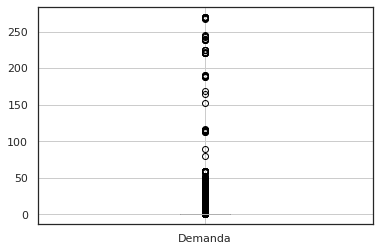

In [342]:
submission.boxplot(['Demanda'])

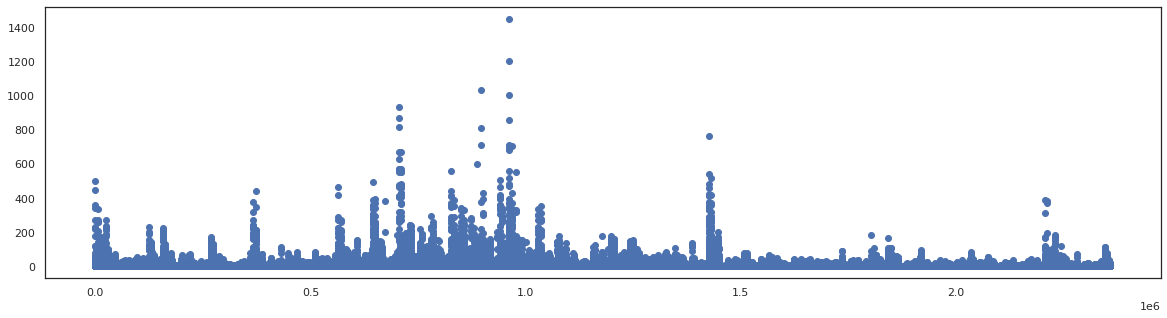

In [343]:
import matplotlib.pyplot as plt

aux = df_train['Demanda'].values

fig = plt.figure(figsize=(20,5))
plt.plot(aux,'o')
plt.show()

In [344]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

prediction = submission['Demanda'].values
df_baseline = pd.read_csv('../../results/Submission_37.csv')
real = df_baseline['Demanda']


y_actual = df_baseline['Demanda']
y_predicted = submission['Demanda'].values

rms = mean_squared_error(y_actual, y_predicted, squared=False)
rms

3.34489281314845

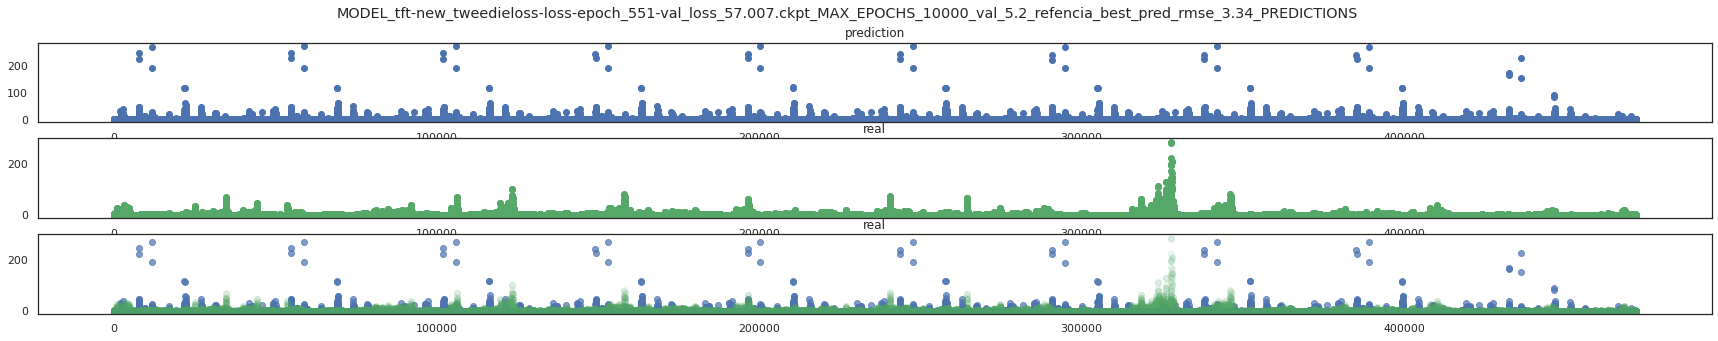

In [345]:


fig = plt.figure(figsize=(30,5),facecolor='white')

plt.subplot(3,1,1)
plt.plot(prediction,'bo')
plt.title('prediction')


plt.subplot(3,1,2)
plt.plot(real,'go')
plt.title('real')

plt.subplot(3,1,3)
plt.plot(prediction,'bo',alpha=0.7,label='prediction')
plt.plot(real,'go',alpha=0.1,label='real')
plt.title('real')

plt.suptitle(best_model_name+'_MAX_EPOCHS_'+str(MAX_EPOCHS)+'_val_'+str(np.round(rmse_val,2))+'_refencia_best_pred_rmse_'+str(np.round(rms,2))+'_PREDICTIONS')
plt.show()

fig.savefig(
            '../../results/models/tft/'+best_model_name+'_MAX_EPOCHS_'+str(MAX_EPOCHS)+'_val_'+str(np.round(rmse_val,2))+'_refencia_best_pred_rmse_'+str(np.round(rms,2))+'_PREDICTIONS.png') 

In [346]:
aux[aux>=300]

array([ 358.,  445.,  339.,  497.,  335.,  319.,  375.,  348.,  442.,
        418.,  466.,  302.,  357.,  305.,  336.,  352.,  495.,  354.,
        307.,  390.,  370.,  340.,  395.,  380.,  404.,  464.,  553.,
        870.,  571.,  934.,  816.,  672.,  571.,  316.,  627.,  474.,
        413.,  410.,  405.,  407.,  423.,  430.,  369.,  476.,  553.,
        475.,  458.,  367.,  314.,  482.,  671.,  567.,  550.,  426.,
        366.,  411.,  409.,  347.,  365.,  438.,  350.,  354.,  557.,
        368.,  386.,  350.,  330.,  342.,  326.,  600.,  375.,  708.,
        808., 1032.,  308.,  426.,  302.,  391.,  502.,  414.,  401.,
        465.,  403.,  304.,  357.,  359.,  391.,  326.,  339.,  326.,
        316.,  338.,  369.,  690., 1005.,  519., 1201., 1451.,  856.,
        395.,  472.,  558.,  332.,  347.,  708.,  678.,  481.,  367.,
        303.,  371.,  334.,  430.,  707.,  310.,  326.,  316.,  552.,
        301.,  337.,  353.,  313.,  355.,  331.,  458.,  539.,  762.,
        481.,  337.,

In [347]:
from sklearn.metrics import mean_squared_error

y_actual = df_baseline['Demanda']
y_predicted = submission['Demanda'].values

rms = mean_squared_error(y_actual, y_predicted, squared=False)
rms

# sin features creados  epochs 10-10  RMSE  =  2.294430400583919
# con features means agg creados  epochs 10 RMSE  =  2.6103579463437967

# sin features creados  epochs 10-10 tweedie p 1.7  = 2.389466613109456
# sin features creados  epochs 10-10  tweedie p 1.5  =  2.295407291713177
# sin features creados  epochs 10-10  tweedie p 1.01  =  2.628891979227094

# sin features creados  epochs 1000-119 tweedie p 1.7  = 4.817909987440523
# sin features creados  epochs 1000-511 tweedie p 1.4 = 3.34489281314845


3.34489281314845

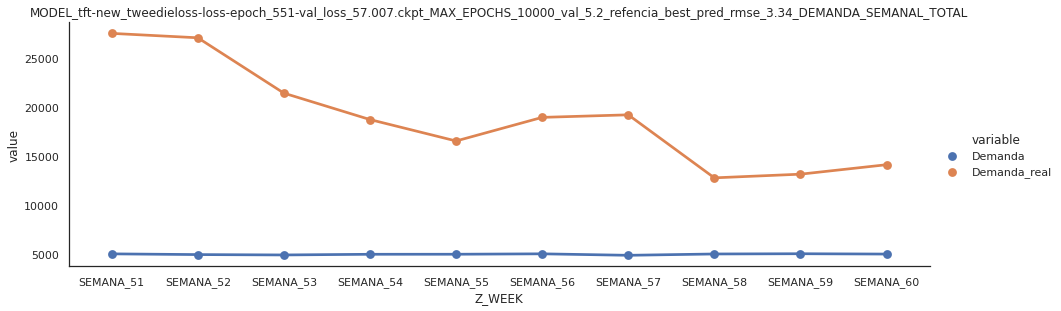

In [348]:
#rmse_val = 3
submission['Demanda_real'] = df_baseline['Demanda']

import plotly.express as px

tendencia_semanal = submission[['Z_WEEK','Demanda','Demanda_real']].groupby(['Z_WEEK']).sum().reset_index()

graph = pd.melt(tendencia_semanal,id_vars=['Z_WEEK'],value_vars=['Demanda','Demanda_real'],)

#fig = px.line(graph,x='Z_WEEK',y='value',color='variable')
#fig.show()
import seaborn as sns
sns.set(style='white')
sns_fig = sns.catplot(x="Z_WEEK", y="value", hue="variable", kind="point", data=graph, height=4.27, aspect=25.7/8.27,facecolor='w')
plt.title(best_model_name+'_MAX_EPOCHS_'+str(MAX_EPOCHS)+'_val_'+str(np.round(rmse_val,2))+'_refencia_best_pred_rmse_'+str(np.round(rms,2))+'_DEMANDA_SEMANAL_TOTAL')
fig = sns_fig.figure
fig.savefig(
            '../../results/models/tft/'+best_model_name+'_MAX_EPOCHS_'+str(MAX_EPOCHS)+'_val_'+str(np.round(rmse_val,2))+'_refencia_best_pred_rmse_'+str(np.round(rms,2))+'_DEMANDA_SEMANAL_TOTAL.png') 

In [349]:
#submission['Demanda'] = 0.9#submission['value']
import numpy as np

submission[['ID', 'Demanda']].to_csv('../../results/models/tft/'+best_model_name+'_MAX_EPOCHS_'+str(MAX_EPOCHS)+'_val_'+str(np.round(rmse_val,2))+'_refencia_best_pred_rmse_'+str(np.round(rms,2))+'_SUBMISSION.csv', index = False, sep = ',')

In [350]:
submission.head(1)

Z_WEEK                                                 ID  Demanda  \
0  SEMANA_51  b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...  0.00029   

   Demanda_real  
0           0.0